<a href="https://colab.research.google.com/github/AlexandruSamoila/trend_analysis/blob/main/src/finetune_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import logging
import matplotlib.pyplot as plt
import os
from datetime import datetime
logging.basicConfig(level=logging.ERROR)

In [3]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/MyDrive/Projects/trend_analysis

/content/drive/MyDrive/Projects/trend_analysis


In [6]:
!ls

checkpoints  data


In [7]:
posts_df = pd.read_json("data/analyzed_trends.json", encoding="utf8")

In [8]:
posts_df.head()

,post,sentiment,label
0,Annonce ✨Vind smykker for i alt 10.000 kr.✨\n\...,positive,2
1,"reklame @ginatricot | Vil du hjælpe mig med, h...",positive,2
2,annonce | Mangler du et julegaveønske? 🫶\nLige...,positive,2
3,Vind 2x valgfrie smykker & 1x smykkeæske fra P...,positive,2
4,annonce Glædelig 3. søndag i advent! 🥰🎄✨\n\nI ...,positive,2


In [9]:
from collections import Counter

class_counts = Counter(posts_df['label'])
print("Before balancing:", class_counts)

# Define a proportion for balancing
negative_size = class_counts[0]  # Keep all negatives
neutral_size = int(negative_size * 1.3)  # Keep 1.3x more neutrals
positive_size = int(negative_size * 1.1)  # Keep 1.1x more positives

balanced_df = pd.DataFrame()

# Sample negative class (keep all)
neg_df = posts_df[posts_df['label'] == 0]

# Sample neutral class (keep more)
neu_df = posts_df[posts_df['label'] == 1].sample(n=min(neutral_size, class_counts[1]), random_state=42)

# Sample positive class (undersample a bit)
pos_df = posts_df[posts_df['label'] == 2].sample(n=min(positive_size, class_counts[2]), random_state=42)

# Combine into balanced dataset
balanced_df = pd.concat([neg_df, neu_df, pos_df])

print("After balancing:", Counter(balanced_df['label']))

Before balancing: Counter({2: 3805, 1: 1212, 0: 161})
After balancing: Counter({1: 209, 2: 177, 0: 161})


In [10]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 215
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
# EPOCHS = 1
LEARNING_RATE = 1e-05
model_type = "cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual" #clapAI/modernBERT-large-multilingual-sentiment
tokenizer = AutoTokenizer.from_pretrained(model_type, truncation=True, do_lower_case=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [11]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.post
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        # Get the actual row using iloc to avoid index issues
        row = self.data.iloc[index]  # Use iloc to access by position
        text = str(row.post)
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(row.label, dtype=torch.long)
        }

In [12]:
train, validate, test = np.split(
        balanced_df.sample(frac=1, random_state=42),
        [int(0.8 * len(balanced_df)), int(0.9 * len(balanced_df))],
    )

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [13]:
print("Train, Validate, Test:",train.shape, validate.shape, test.shape)

Train, Validate, Test: (437, 3) (55, 3) (55, 3)


In [14]:
training_set = SentimentData(train, tokenizer, MAX_LEN)
validation_set = SentimentData(validate, tokenizer, MAX_LEN)
test_set = SentimentData(test, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 1,
                'pin_memory' : False
                }
valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 1,
                'pin_memory' : False
                }
test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 1,
                 'pin_memory' : False
                }
training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **valid_params)
test_loader = DataLoader(test_set, **test_params)

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(model_type)
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [16]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [17]:

def one_epoch(model, data_loader, loss_fn, opt=None):
    """
    Runs one epoch of training or validation.

    Args:
        model: The model to be trained or evaluated.
        data_loader: DataLoader object that loads the batch of data.
        loss_fn: The loss function to optimize.
        opt: Optimizer for training phase (None during evaluation).

    Returns:
        avg_loss: Average loss over the epoch.
    """

    # Set the model to training or evaluation mode based on the optimizer
    train = False if opt is None else True
    model.train() if train else model.eval()
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0

    losses = []
    for _,data in enumerate(data_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        # Enable gradient computation only during training
        with torch.set_grad_enabled(train):
            outputs = model(ids, mask, token_type_ids).logits
        loss = loss_fn(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        # if _%5000==0:
        #     loss_step = tr_loss/nb_tr_steps
        #     accu_step = (n_correct*100)/nb_tr_examples
        #     print(f"Training Loss per 5000 steps: {loss_step}")
        #     print(f"Training Accuracy per 5000 steps: {accu_step}")

        if train:
            opt.zero_grad()  # Reset gradients
            loss.backward()  # Backpropagate gradients
            opt.step()  # Update model parameters
            # if scheduler:
            #     scheduler.step()

        losses.append(loss.item())

    avg_loss = np.mean(losses)
    # print(f'The Total Accuracy for Epoch: {(n_correct*100)/nb_tr_examples}')
    # epoch_loss = tr_loss/nb_tr_steps
    # epoch_accu = (n_correct*100)/nb_tr_examples
    # print(f"Training Loss Epoch: {epoch_loss}")
    # print(f"Training Accuracy Epoch: {epoch_accu}")
    return avg_loss

def train(
    model,
    train_loader,
    val_loader,
    lr=1e-3,
    max_epochs=3,
    weight_decay=0.01,
    patience=3,
):
    """
    Trains the model using the provided training and validation data loaders.

    Args:
        model: The neural network model to train.
        train_loader: DataLoader object for the training set.
        val_loader: DataLoader object for the validation set.
        lr: Learning rate for the optimizer. Default is 1e-3.
        max_epochs: Maximum number of epochs to train. Default is 30.
        weight_decay: Weight decay for L2 regularization. Default is 0.01.
        patience: Number of epochs with no improvement after which training will stop. Default is 3.

    Returns:
        train_losses: List of training losses per epoch.
        valid_losses: List of validation losses per epoch.
    """

    # Initialize the optimizer
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn = torch.nn.CrossEntropyLoss()
    best_valid_loss = float("inf")  # Initialize best validation loss
    patience_counter = 0  # Counter for early stopping
    train_losses, valid_losses = [], []  # Track losses for plotting/analysis
    best_model_state = None  # Store the best model's state_dict

    # Training loop
    t = tqdm(range(max_epochs))
    for epoch in t:
        # Training phase
        train_loss = one_epoch(model, train_loader, loss_fn, opt)
        # Validation phase
        valid_loss = one_epoch(model, val_loader, loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0  # Reset counter if validation loss improves
            best_model_state = model.state_dict() # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch}")
                break

        t.set_description(f"train loss: {train_loss:.4f}, val loss: {valid_loss:.4f}")
    # Load the best model state before returning
    model.load_state_dict(best_model_state)
    return train_losses, valid_losses

def plot_history(train_losses, valid_losses):
    """
    Plots the training and validation loss history over epochs.

    Args:
        train_losses: List of training losses for each epoch.
        valid_losses: List of validation losses for each epoch.
    """
    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, label="train")
    plt.plot(valid_losses, label="valid")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

Begin training ...


train loss: 0.4178, val loss: 0.6063: 100%|██████████| 3/3 [00:55<00:00, 18.63s/it]


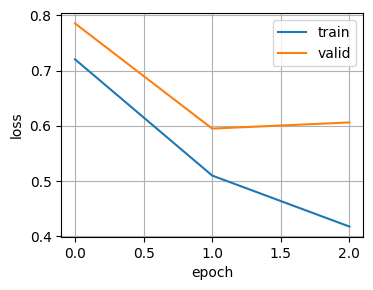

In [22]:
EPOCHS = 3
PATIENCE = 2
WEIGHT_DECAY = 0.02

# Start the training process and plot the training history
print("Begin training ...")
plot_history(
    *train(
        model,
        training_loader,
        validation_loader,
        lr=LEARNING_RATE,
        max_epochs=EPOCHS,
        weight_decay=WEIGHT_DECAY,
        patience=PATIENCE,
    )
)



In [19]:
# Save the trained model and its hyperparameters
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
# Folder name to save the trained model
models_dir = "checkpoints"
os.makedirs(models_dir, exist_ok=True)

# Create model name with hyperparameters
model_name = "roberta_sentiment"

# Construct the path for saving the model
save_dir = os.path.join(models_dir, f"{timestamp}_{model_name}")
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "model.bin")
model.save_pretrained(save_dir)
# torch.save(model.state_dict(), model_path)
tokenizer.save_vocabulary(save_dir)
print("Model saved!")

Model saved!


In [23]:
import gc
del model
torch.cuda.empty_cache()  # Free GPU memory
gc.collect()


3317

In [ ]:
!ls

checkpoints  data


In [24]:
test_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Projects/trend_analysis/checkpoints/20250407_1450_roberta_sentiment")
test_model.eval()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [25]:
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def evaluate_model(model, data_loader):
    n_correct = 0
    nb_tr_examples = 0
    all_predictions = []
    all_true_ratings = []
    class_counts = defaultdict(lambda: {"correct": 0, "total": 0})

    with torch.no_grad():
      for _,data in enumerate(data_loader):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.long)

          outputs = model(ids, mask, token_type_ids).logits

          _, predictions = torch.max(outputs.data, dim=1)
          # Store for confusion matrix
          all_predictions.extend(predictions.cpu().numpy())
          all_true_ratings.extend(targets.cpu().numpy())
          n_correct += calcuate_accuracy(predictions, targets)
          nb_tr_examples+=targets.size(0)
          # Update class-specific counts
          for true_label, pred_label in zip(targets.cpu().numpy(), predictions.cpu().numpy()):
              class_counts[true_label]["total"] += 1
              if true_label == pred_label:
                  class_counts[true_label]["correct"] += 1
    # Print results for each class
    print("\nPerformance per class:")
    for sentiment_class, counts in sorted(class_counts.items()):
        correct = counts["correct"]
        total = counts["total"]
        print(f"Class {sentiment_class}: {correct}/{total} correct ({(correct/total)*100:.2f}%)")

    # Compute confusion matrix
    cm = confusion_matrix(all_true_ratings, all_predictions, normalize='true')
    class_labels = sorted(class_counts.keys())  # Ensure correct class ordering

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(all_true_ratings, all_predictions, digits=2))



Performance per class:
Class 0: 14/16 correct (87.50%)
Class 1: 17/21 correct (80.95%)
Class 2: 15/18 correct (83.33%)


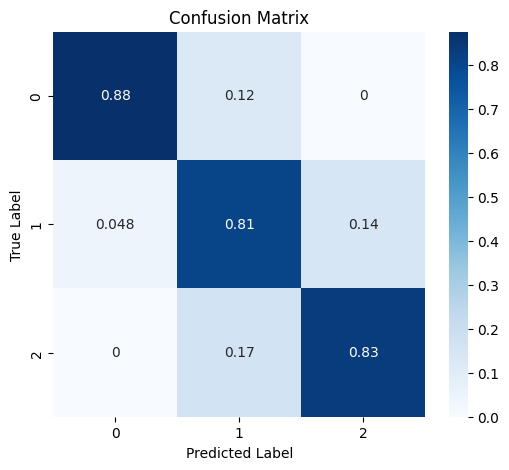

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.77      0.81      0.79        21
           2       0.83      0.83      0.83        18

    accuracy                           0.84        55
   macro avg       0.85      0.84      0.84        55
weighted avg       0.84      0.84      0.84        55



In [26]:
test_model.to(device)
evaluate_model(test_model, test_loader)


Performance per class:
Class 0: 12/16 correct (75.00%)
Class 1: 8/21 correct (38.10%)
Class 2: 11/18 correct (61.11%)


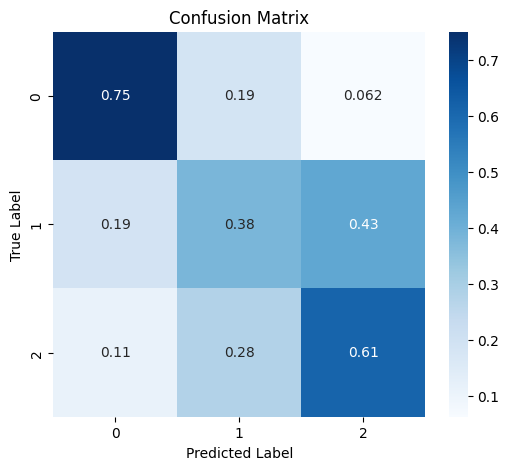

              precision    recall  f1-score   support

           0       0.67      0.75      0.71        16
           1       0.50      0.38      0.43        21
           2       0.52      0.61      0.56        18

    accuracy                           0.56        55
   macro avg       0.56      0.58      0.57        55
weighted avg       0.56      0.56      0.56        55

None


In [27]:
init_model = AutoModelForSequenceClassification.from_pretrained(model_type)#"cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual")
init_model.to(device)
init_model.eval()
print(evaluate_model(init_model, test_loader))

In [28]:
del init_model
del test_model
torch.cuda.empty_cache()  # Free GPU memory
gc.collect()

10076